# AutoMpg Dataset
"The data concerns city-cycle fuel consumption in miles per gallon, to be predicted in terms of 3 multivalued discrete and 5 continuous attributes." (Quinlan, 1993)"
- 398 instances
- 7 features

In [1]:
import pandas as pd
import numpy as np
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.ensemble import RandomForestRegressor as SklearnRandomForestRegressor
from sklearn.linear_model import LinearRegression


import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

### Loading Configuration and Data

In [2]:
from utils.data_loader import load_config
from utils.evaluation import evaluate_model, plot_results
from utils.modelling import grid_search_custom_model, RegressionTreeScratch, RandomForestRegressorScratch, RandomForestRegressorLLM

In [3]:
config = load_config("config.yaml")

In [4]:
data_path = config['paths']['path_auto']
columns = [
    "mpg", "cylinders", "displacement", "horsepower",
    "weight", "acceleration", "model_year", "origin", "car_name"
]
auto_data = pd.read_csv(data_path, delim_whitespace=True, names=columns, na_values="?")

### Data Analysis

In [5]:
print(auto_data.head())

    mpg  cylinders  displacement  horsepower  weight  acceleration  \
0  18.0          8         307.0       130.0  3504.0          12.0   
1  15.0          8         350.0       165.0  3693.0          11.5   
2  18.0          8         318.0       150.0  3436.0          11.0   
3  16.0          8         304.0       150.0  3433.0          12.0   
4  17.0          8         302.0       140.0  3449.0          10.5   

   model_year  origin                   car_name  
0          70       1  chevrolet chevelle malibu  
1          70       1          buick skylark 320  
2          70       1         plymouth satellite  
3          70       1              amc rebel sst  
4          70       1                ford torino  


In [6]:
print(auto_data.describe())

              mpg   cylinders  displacement  horsepower       weight  \
count  398.000000  398.000000    398.000000  392.000000   398.000000   
mean    23.514573    5.454774    193.425879  104.469388  2970.424623   
std      7.815984    1.701004    104.269838   38.491160   846.841774   
min      9.000000    3.000000     68.000000   46.000000  1613.000000   
25%     17.500000    4.000000    104.250000   75.000000  2223.750000   
50%     23.000000    4.000000    148.500000   93.500000  2803.500000   
75%     29.000000    8.000000    262.000000  126.000000  3608.000000   
max     46.600000    8.000000    455.000000  230.000000  5140.000000   

       acceleration  model_year      origin  
count    398.000000  398.000000  398.000000  
mean      15.568090   76.010050    1.572864  
std        2.757689    3.697627    0.802055  
min        8.000000   70.000000    1.000000  
25%       13.825000   73.000000    1.000000  
50%       15.500000   76.000000    1.000000  
75%       17.175000   79.0000

In [7]:
print(auto_data.isnull().sum())

mpg             0
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model_year      0
origin          0
car_name        0
dtype: int64


##### Target Analysis

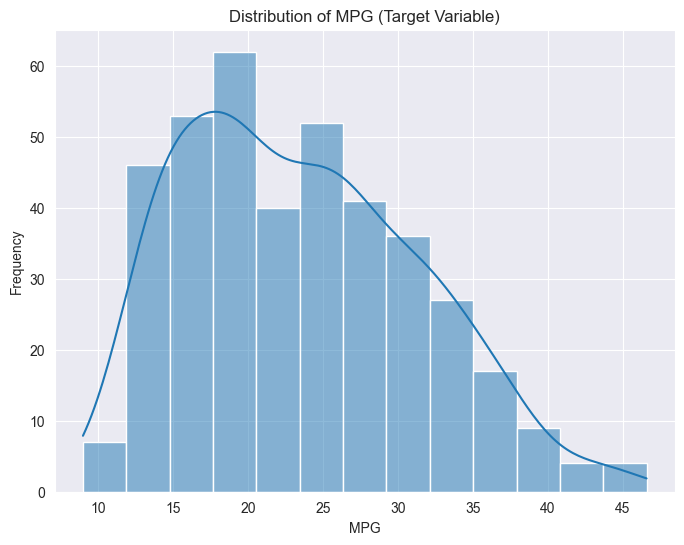

In [8]:
plt.figure(figsize=(8, 6))
sns.histplot(auto_data['mpg'], kde=True)
plt.title('Distribution of MPG (Target Variable)')
plt.xlabel('MPG')
plt.ylabel('Frequency')
plt.show()

##### Numerical Variables Analysis 

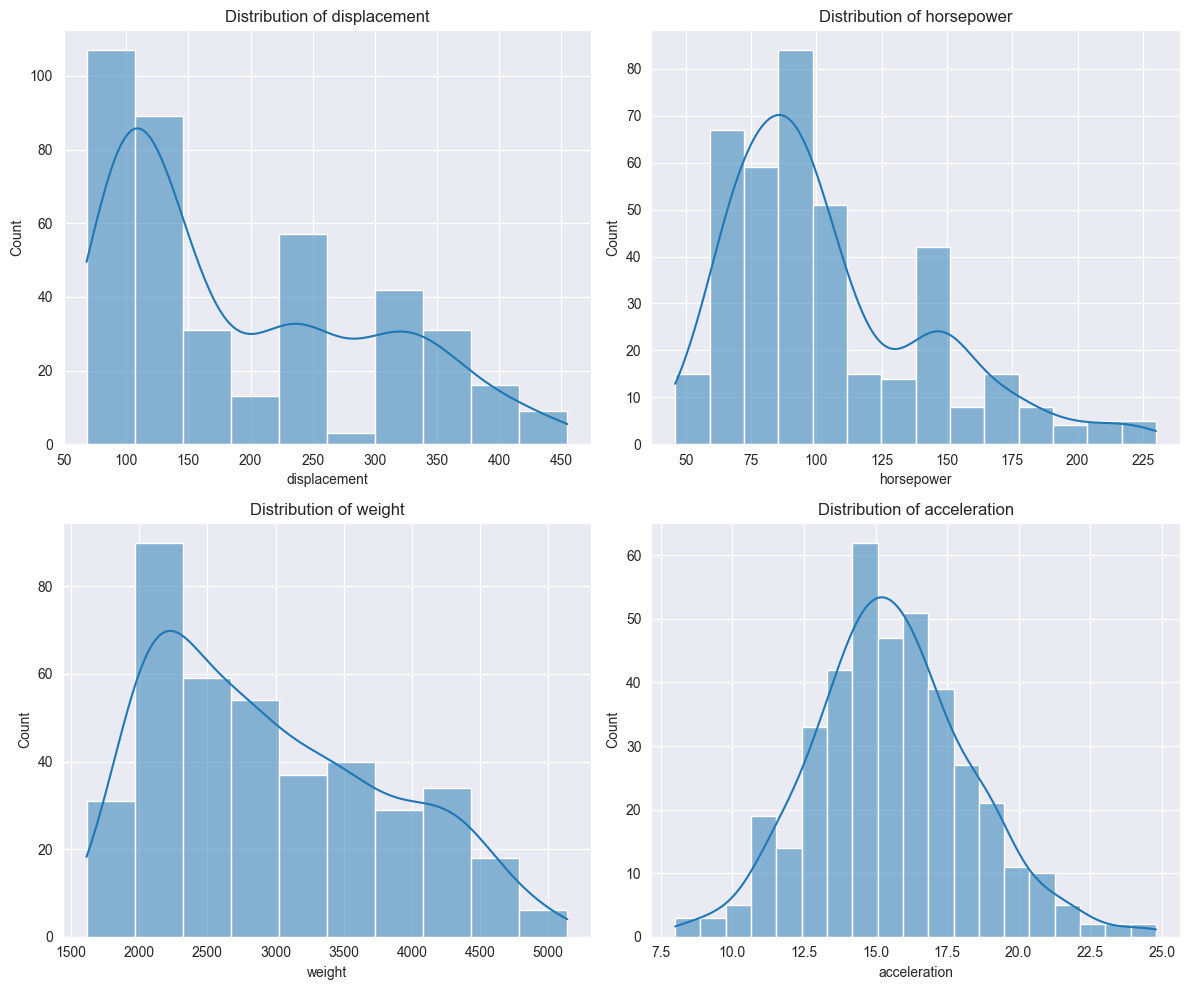

In [9]:
numerical_f = ["displacement", "horsepower", "weight", "acceleration"]
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, feature in enumerate(numerical_f):
    sns.histplot(auto_data[feature].dropna(), kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of {feature}")

plt.tight_layout()
plt.show()

##### Categorical Variables Analysis 

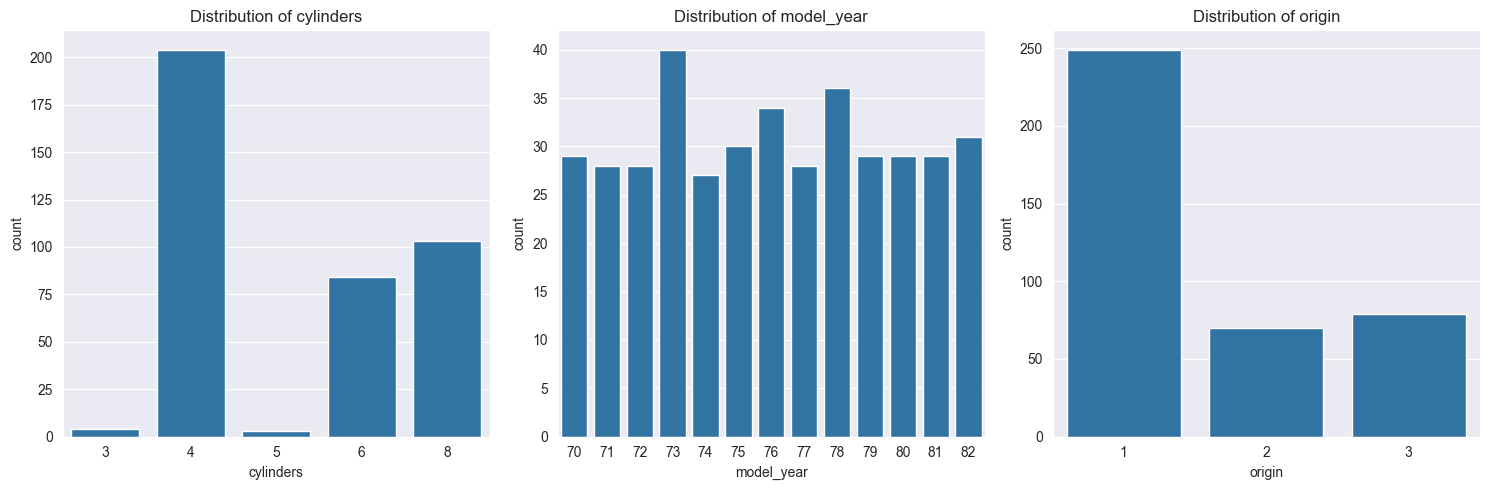

In [10]:
categorical_f = ["cylinders", "model_year", "origin"]
fig, axes = plt.subplots(1, len(categorical_f), figsize=(15, 5))
axes = axes.flatten()

for i, feature in enumerate(categorical_f):
    sns.countplot(data=auto_data, x=feature, ax=axes[i])
    axes[i].set_title(f"Distribution of {feature}")

plt.tight_layout()
plt.show()

##### Coorelation Analysis

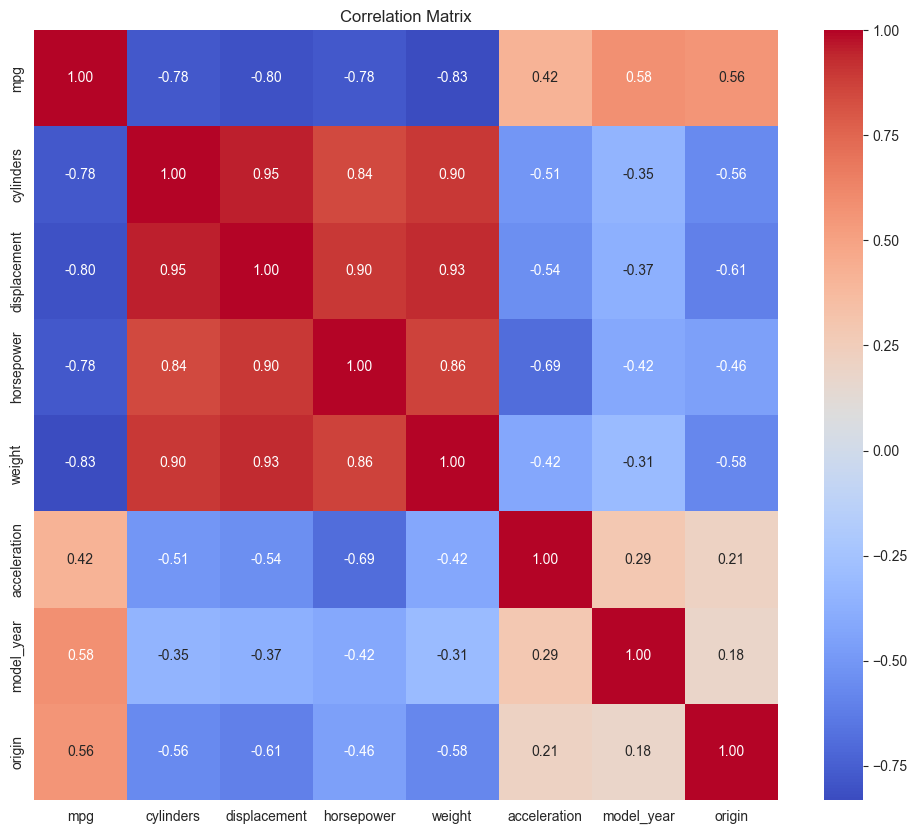

In [11]:
numerical_columns = auto_data.select_dtypes(include=[np.number]).columns

plt.figure(figsize=(12, 10))
sns.heatmap(auto_data[numerical_columns].corr(), annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix")
plt.show()

### Data Splitting & Preprocessing

In [12]:
auto_data = auto_data.drop('car_name', axis=1)

In [13]:
X = auto_data.drop('mpg', axis=1)
y = auto_data['mpg']

In [14]:
test_size = config['split']['test_size']
validation_size = config['split']['validation_size']
random_state = config['split']['random_state']

In [15]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y,
    test_size=test_size,
    random_state=random_state
)
val_size_relative = validation_size / (1 - test_size)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=val_size_relative,
    random_state=random_state
)
print(X_train.shape[0])
print(X_val.shape[0])
print(X_test.shape[0])

278
40
80


In [16]:
imputer = SimpleImputer(strategy='median')
X_train['horsepower'] = imputer.fit_transform(X_train[['horsepower']])
X_val['horsepower'] = imputer.transform(X_val[['horsepower']])
X_test['horsepower'] = imputer.transform(X_test[['horsepower']])

## Modelling

In [18]:
custom_rf_param_grid = {
    'n_estimators': config['rf_params']['n_trees'], 
    'max_depth': config['rf_params']['max_depth'],
    'min_samples_split': config['rf_params']['min_samples_split'],
    'max_features': config['rf_params']['max_features']
}

#### Random Forest Regression tree from Scratch

In [19]:
# Perform grid search for custom RF
best_custom_rf_params, best_custom_rf_score, custom_rf_results = grid_search_custom_model(
    RandomForestRegressorScratch, custom_rf_param_grid, X_train.values, y_train.values
)

In [20]:
# Train the best Custom RF on the entire training set
best_custom_rf = RandomForestRegressorScratch(**best_custom_rf_params)
best_custom_rf.fit(X_train.values, y_train.values)


#### LLM Random Forest Regression tree from Scratch

In [21]:
# LLM Random Forest
llm_rf_param_grid = custom_rf_param_grid  # Same parameter grid as Custom RF
best_llm_rf_params, best_llm_rf_score, llm_rf_results = grid_search_custom_model(
    RandomForestRegressorLLM, llm_rf_param_grid, X_train.values, y_train.values
)

In [22]:
# Train the best LLM RF on the entire training set
best_llm_rf = RandomForestRegressorLLM(**best_llm_rf_params)
best_llm_rf.fit(X_train.values, y_train.values)

#### Random forest from Sklearn

In [23]:
# Sklearn Random Forest with GridSearchCV
rf_grid = GridSearchCV(SklearnRandomForestRegressor(random_state=random_state), custom_rf_param_grid, cv=5)
rf_grid.fit(X_train, y_train)
best_rf_model = rf_grid.best_estimator_

#### Linear Regression

In [24]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

## Prediction

In [25]:
custom_rf_test_metrics = evaluate_model(y_test, best_custom_rf.predict(X_test.values))
llm_rf_test_metrics = evaluate_model(y_test, best_llm_rf.predict(X_test.values))
rf_test_metrics = evaluate_model(y_test, best_rf_model.predict(X_test))
lr_test_metrics = evaluate_model(y_test, lr.predict(X_test))

## Evaluation

In [26]:
test_results = {
    "Custom Random Forest": custom_rf_test_metrics,
    "LLM Random Forest": llm_rf_test_metrics,
    "Sklearn Random Forest": rf_test_metrics,
    "Linear Regression": lr_test_metrics
}

print("\nTest Results:")
for model, metrics in test_results.items():
    print(f"{model}: {metrics}")



Test Results:
Custom Random Forest: {'MSE': 5.318644805446725, 'MAE': 1.6574756501183394, 'R2': 0.9010787317424779}
LLM Random Forest: {'MSE': 5.778101709901138, 'MAE': 1.736479392139723, 'R2': 0.8925333106134412}
Sklearn Random Forest: {'MSE': 4.9547977693730685, 'MAE': 1.592735329402834, 'R2': 0.9078459086412412}
Linear Regression: {'MSE': 8.37299111600188, 'MAE': 2.291017023590067, 'R2': 0.8442710632874639}


In [27]:
test_results_df = pd.DataFrame(test_results).T
test_results_df.to_csv("test_results.csv", index=True)


In [28]:
#best parameters for custom RF and LLM RF
print("\nBest Parameters for Custom Random Forest:", best_custom_rf_params)
print("Best Cross-Validation Score for Custom Random Forest:", best_custom_rf_score)
print("\nBest Parameters for LLM Random Forest:", best_llm_rf_params)
print("Best Cross-Validation Score for LLM Random Forest:", best_llm_rf_score)


Best Parameters for Custom Random Forest: {'max_depth': 10, 'max_features': None, 'min_samples_split': 2, 'n_estimators': 100}
Best Cross-Validation Score for Custom Random Forest: 8.402479660520791

Best Parameters for LLM Random Forest: {'max_depth': 10, 'max_features': None, 'min_samples_split': 2, 'n_estimators': 50}
Best Cross-Validation Score for LLM Random Forest: 8.564745887326001



Test Results Summary:
                            MSE       MAE        R2
Custom Random Forest   5.318645  1.657476  0.901079
LLM Random Forest      5.778102  1.736479  0.892533
Sklearn Random Forest  4.954798  1.592735  0.907846
Linear Regression      8.372991  2.291017  0.844271


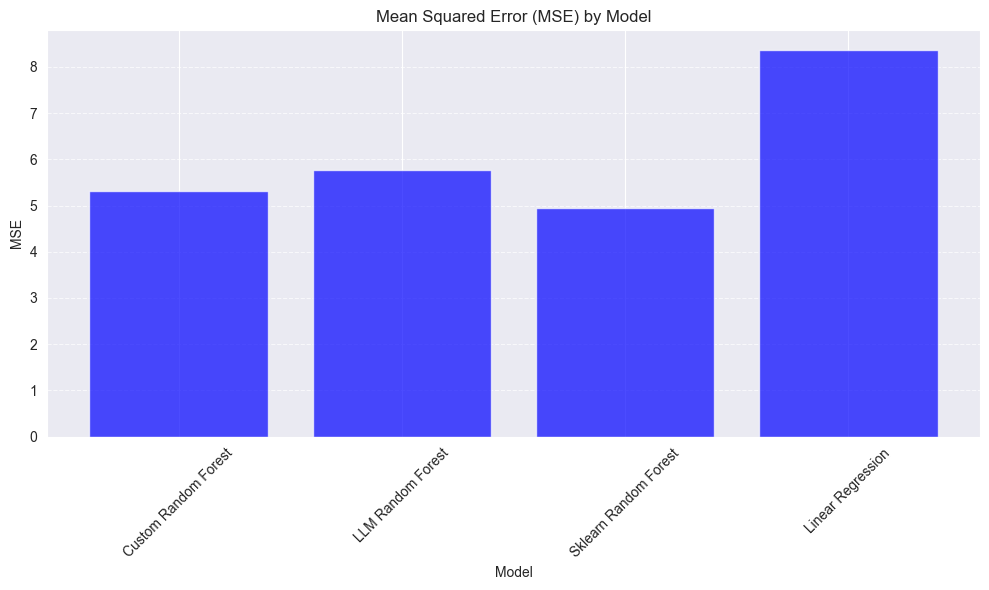

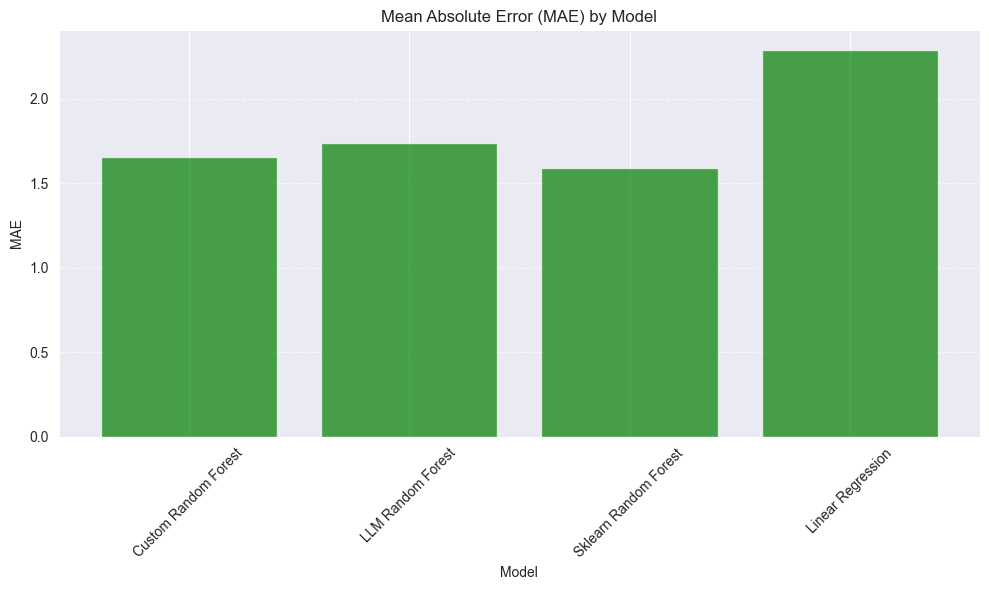

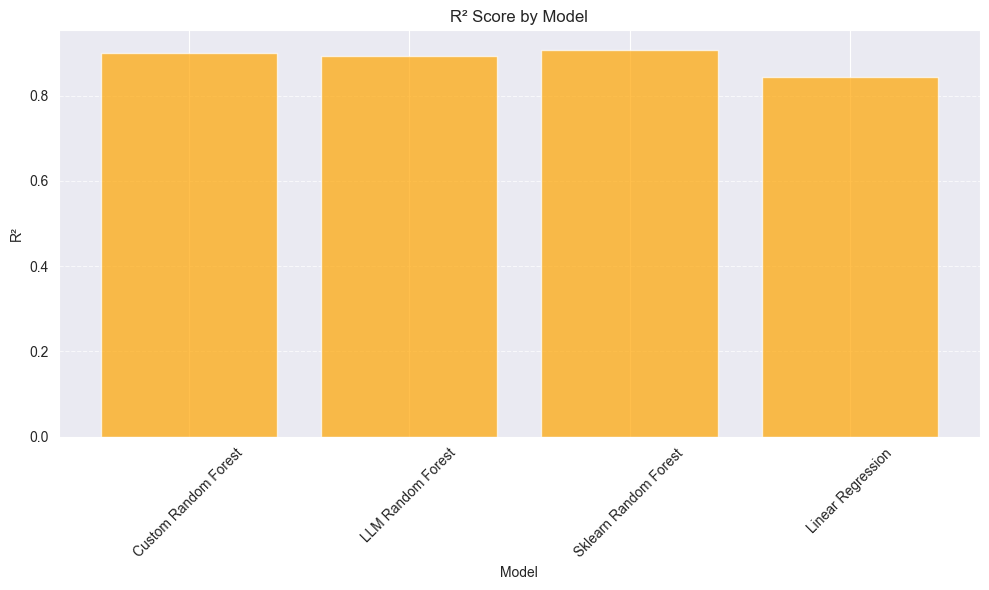

In [29]:
# df for visualization
metrics_flattened = {k: {metric: value for metric, value in v.items()} for k, v in test_results.items()}
test_results_flattened_df = pd.DataFrame.from_dict(metrics_flattened, orient='index')

#save to CSV
test_results_flattened_df.to_csv("detailed_test_results.csv", index=True)

print("\nTest Results Summary:")
print(test_results_flattened_df)

plot_results(test_results_flattened_df)